In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, mean, lower, stddev, udf
from pyspark.sql.types import StringType

# Initialize Spark session with adjusted configuration
spark = SparkSession.builder \
    .appName("DataCleaning") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .getOrCreate()

# Set log level to WARN
spark.sparkContext.setLogLevel("WARN")

24/05/20 17:06:22 WARN Utils: Your hostname, shivus-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.13.228.124 instead (on interface en0)
24/05/20 17:06:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 17:06:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load datasets
myntra_df = spark.read.csv("myntra_catalog.csv", header=True, inferSchema=True)

In [4]:
# Display schema information
print("Schema information for Myntra catalog:")
myntra_df.printSchema()

Schema information for Myntra catalog:
root
 |-- ProductID: integer (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- ProductBrand: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Myntra_Price: integer (nullable = true)
 |-- NumImages: integer (nullable = true)
 |-- PrimaryColor: string (nullable = true)



In [5]:
# Summary statistics for Myntra catalog
print("Summary statistics for Myntra catalog:")
myntra_df.describe().show()

Summary statistics for Myntra catalog:
+-------+------------------+--------------------+------------+------+------------------+------------------+------------+
|summary|         ProductID|         ProductName|ProductBrand|Gender|      Myntra_Price|         NumImages|PrimaryColor|
+-------+------------------+--------------------+------------+------+------------------+------------------+------------+
|  count|              1004|                1004|        1004|  1004|              1004|              1004|         952|
|   mean| 9669231.660358565|                NULL|        NULL|  NULL|1735.6533864541832| 4.607569721115538|        NULL|
| stddev|1720119.1805550538|                NULL|        NULL|  NULL|2900.2875116834894|1.1727133921037416|        NULL|
|    min|           1000182|AIGNER Men Blue E...|      AIGNER|  Boys|               259|                 1|       Beige|
|    max|          10033715|shaze Women Silve...|       shaze| Women|             31100|                 7|Turkish

In [6]:
# Display first few rows of Myntra catalog
print("First few rows of Myntra catalog:")
myntra_df.show(5)


First few rows of Myntra catalog:
+---------+--------------------+------------+------+------------+---------+------------+
|ProductID|         ProductName|ProductBrand|Gender|Myntra_Price|NumImages|PrimaryColor|
+---------+--------------------+------------+------+------------+---------+------------+
| 10017413|DKNY Unisex Black...|        DKNY|Unisex|       11745|        7|       Black|
| 10016283|EthnoVogue Women ...|  EthnoVogue| Women|        5810|        7|       Beige|
| 10009781|SPYKAR Women Pink...|      SPYKAR| Women|         899|        7|        Pink|
| 10015921|Raymond Men Blue ...|     Raymond|   Men|        5599|        5|        Blue|
| 10017833|Parx Men Brown & ...|        Parx|   Men|         759|        5|       White|
+---------+--------------------+------------+------+------------+---------+------------+
only showing top 5 rows



# Data Cleaning

In [8]:
# Display the count of missing values in each column
print("Missing values in Myntra catalog:")
myntra_df.select([count(when(col(c).isNull(), c)).alias(c) for c in myntra_df.columns]).show()


Missing values in Myntra catalog:
+---------+-----------+------------+------+------------+---------+------------+
|ProductID|ProductName|ProductBrand|Gender|Myntra_Price|NumImages|PrimaryColor|
+---------+-----------+------------+------+------------+---------+------------+
|        0|          0|           0|     0|           0|        0|          52|
+---------+-----------+------------+------+------------+---------+------------+



In [9]:
# Identify and count duplicates in Myntra dataset
myntra_duplicates = myntra_df.groupBy(myntra_df.columns).count().filter("count > 1")
num_myntra_duplicates = myntra_duplicates.count()
print(f"Number of duplicates in Myntra dataset: {num_myntra_duplicates}")

# Remove duplicates
myntra_df = myntra_df.dropDuplicates()




Number of duplicates in Myntra dataset: 0


In [10]:
# Impute missing values for numerical columns with mean
myntra_price_mean = myntra_df.select(mean('Myntra_Price')).collect()[0][0]
myntra_df = myntra_df.na.fill({'Myntra_Price': myntra_price_mean})

# Drop rows with missing values in crucial columns
myntra_df = myntra_df.na.drop(subset=['ProductName', 'Gender'])

In [11]:
# Remove duplicates
myntra_df = myntra_df.dropDuplicates(['ProductID'])

In [12]:

# Standardize text data to lower case
myntra_df = myntra_df.withColumn('Gender', lower(col('Gender')))

In [13]:

# Function to filter outliers based on Z-score
def filter_outliers(df, column):
    stats = df.select(mean(col(column)), stddev(col(column))).first()
    mean_val, stddev_val = stats[0], stats[1]
    return df.filter((col(column) > (mean_val - 3 * stddev_val)) & (col(column) < (mean_val + 3 * stddev_val)))

myntra_df = filter_outliers(myntra_df, 'Myntra_Price')

In [14]:

# Ensure correct data types
myntra_df = myntra_df.withColumn('Myntra_Price', col('Myntra_Price').cast('float'))

In [15]:
# Display cleaned data
print("Cleaned Myntra catalog data:")
myntra_df.show(10)

Cleaned Myntra catalog data:
+---------+--------------------+-------------------+------+------------+---------+------------+
|ProductID|         ProductName|       ProductBrand|Gender|Myntra_Price|NumImages|PrimaryColor|
+---------+--------------------+-------------------+------+------------+---------+------------+
|  1000182|Jn Joy Navy Sheer...|             Jn Joy| women|      2399.0|        6|        Navy|
|  1000353|Kook N Keech Disn...|Kook N Keech Disney| women|       839.0|        5|        Blue|
|  1000488|Russell Athletic ...|   Russell Athletic| women|      2799.0|        5|        Grey|
|  1000494|Russell Athletic ...|   Russell Athletic| women|      2999.0|        5|       Black|
|  1000497|Russell Athletic ...|   Russell Athletic| women|      2599.0|        5|        Grey|
|  1000505|Russell Athletic ...|   Russell Athletic| women|      3499.0|        5|       Black|
|  1000507|Russell Athletic ...|   Russell Athletic| women|      2999.0|        5|       Black|
|  1000709|

# EDA for Myntra Dataset

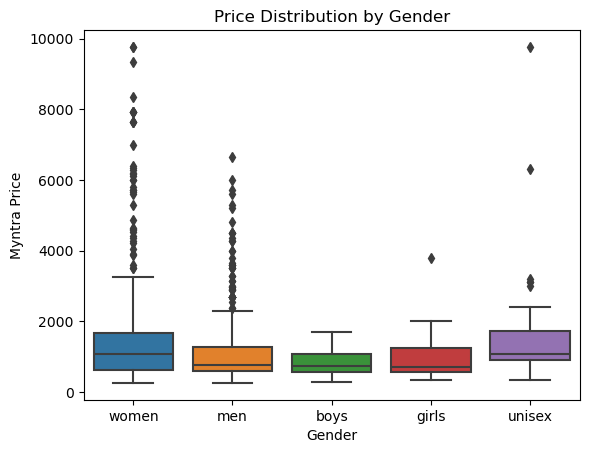

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
myntra_pandas_df = myntra_df.toPandas()


# Now use the Pandas DataFrame for plotting
sns.boxplot(x='Gender', y='Myntra_Price', data=myntra_pandas_df)
plt.title('Price Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Myntra Price')
plt.show()


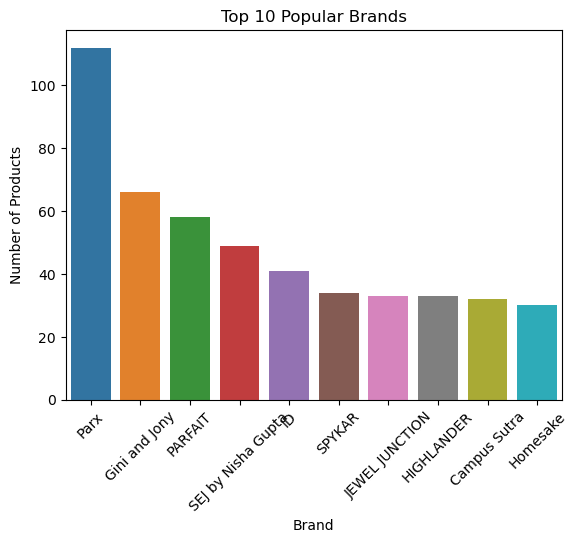

In [18]:
brand_counts = myntra_pandas_df['ProductBrand'].value_counts().head(10)  # Top 10 brands
sns.barplot(x=brand_counts.index, y=brand_counts.values)
plt.title('Top 10 Popular Brands')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


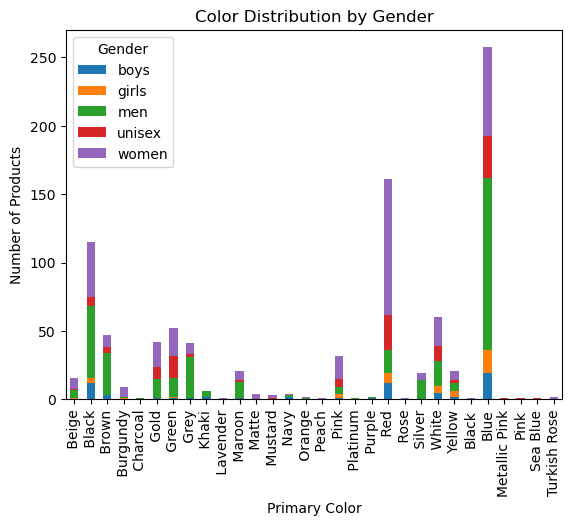

In [19]:
color_gender = myntra_pandas_df.groupby(['PrimaryColor', 'Gender']).size().unstack()
color_gender.plot(kind='bar', stacked=True)
plt.title('Color Distribution by Gender')
plt.xlabel('Primary Color')
plt.ylabel('Number of Products')
plt.show()


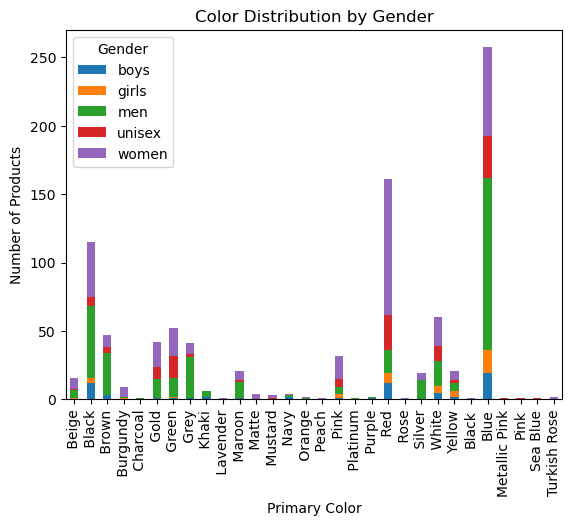

In [20]:
color_gender = myntra_pandas_df.groupby(['PrimaryColor', 'Gender']).size().unstack()
color_gender.plot(kind='bar', stacked=True)
plt.title('Color Distribution by Gender')
plt.xlabel('Primary Color')
plt.ylabel('Number of Products')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


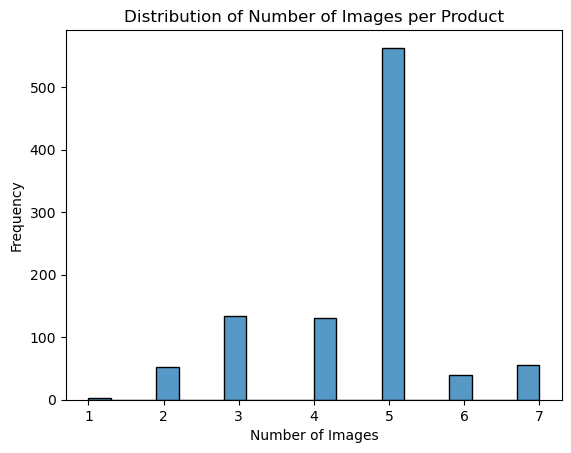

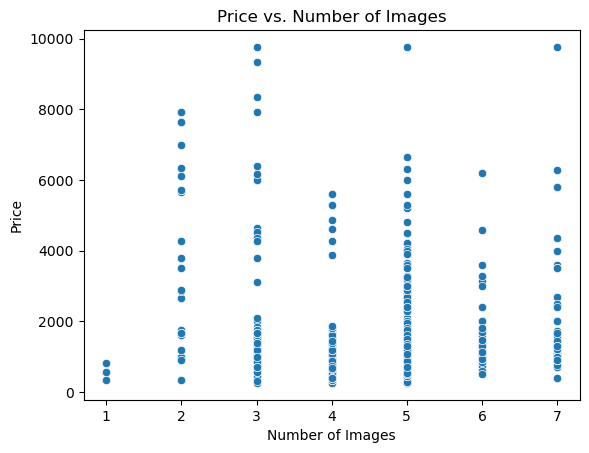

In [21]:
sns.histplot(myntra_pandas_df['NumImages'], bins=20, kde=False)
plt.title('Distribution of Number of Images per Product')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.show()

#Price vs. Number of Images

sns.scatterplot(x='NumImages', y='Myntra_Price', data=myntra_pandas_df)
plt.title('Price vs. Number of Images')
plt.xlabel('Number of Images')
plt.ylabel('Price')
plt.show()


# BigBasket Dataset 

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, mean, lower, stddev, udf
from pyspark.sql.types import StringType

# Initialize Spark session with adjusted configuration
spark = SparkSession.builder \
    .appName("DataCleaning") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .getOrCreate()

# Set log level to WARN
spark.sparkContext.setLogLevel("WARN")

In [24]:
# Load datasets

bigbasket_df = spark.read.csv("Bigbasket_catlog.csv", header=True, inferSchema=True)

In [25]:
# Schema information for BigBasket products
print("Schema information for BigBasket products:")
bigbasket_df.printSchema()

Schema information for BigBasket products:
root
 |-- ProductID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub_category: string (nullable = true)
 |-- ProductBrand: string (nullable = true)
 |-- Price  : double (nullable = true)
 |-- Market_price: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Rating: double (nullable = true)



## Data Cleaning

### Missing Values

In [28]:
# Display the count of missing values in each column

print("Missing values in BigBasket products:")
bigbasket_df.select([count(when(col(c).isNull(), c)).alias(c) for c in bigbasket_df.columns]).show()


Missing values in BigBasket products:
+---------+-------+--------+------------+------------+-------+------------+----+------+
|ProductID|Product|Category|Sub_category|ProductBrand|Price  |Market_price|Type|Rating|
+---------+-------+--------+------------+------------+-------+------------+----+------+
|        0|      0|       0|           0|           0|      0|           0|   0|   306|
+---------+-------+--------+------------+------------+-------+------------+----+------+



### Duplicates Values

In [30]:
# Identify and count duplicates in BigBasket dataset
bigbasket_duplicates = bigbasket_df.groupBy(bigbasket_df.columns).count().filter("count > 1")
num_bigbasket_duplicates = bigbasket_duplicates.count()
print(f"Number of duplicates in BigBasket dataset: {num_bigbasket_duplicates}")


# Remove duplicates
bigbasket_df = bigbasket_df.dropDuplicates()


Number of duplicates in BigBasket dataset: 0


In [31]:
# Standardize text data to lower case
bigbasket_df = bigbasket_df.withColumn('category', lower(col('category')))


In [32]:
# Function to filter outliers based on Z-score
def filter_outliers(df, column):
    stats = df.select(mean(col(column)), stddev(col(column))).first()
    mean_val, stddev_val = stats[0], stats[1]
    return df.filter((col(column) > (mean_val - 3 * stddev_val)) & (col(column) < (mean_val + 3 * stddev_val)))
    bigbasket_df = bigbasket_df.withColumn('sale_price', col('sale_price').cast('float'))



In [33]:
# Display cleaned data
print("Cleaned BigBasket catalog data:")
bigbasket_df.show(10)

Cleaned BigBasket catalog data:
+---------+--------------------+--------------------+--------------------+-------------------+-------+------------+--------------------+------+
|ProductID|             Product|            category|        Sub_category|       ProductBrand|Price  |Market_price|                Type|Rating|
+---------+--------------------+--------------------+--------------------+-------------------+-------+------------+--------------------+------+
|       71|Kids Motu Patlu T...|    beauty & hygiene|           Oral Care|            Colgate|   43.0|        43.0|          Toothpaste|   4.0|
|       83|Organic Dal - Masoor|foodgrains, oil &...|     Organic Staples|         Pro Nature|   96.0|        96.0|Organic Dals & Pu...|   3.9|
|      980|Microfiber Multip...|cleaning & household|Mops, Brushes & S...|               Gala|  140.0|       140.0|  Dust Cloth & Wipes|   4.1|
|      991|Bounce Biscuits -...|snacks & branded ...|  Biscuits & Cookies|           Sunfeast|   27.0|  

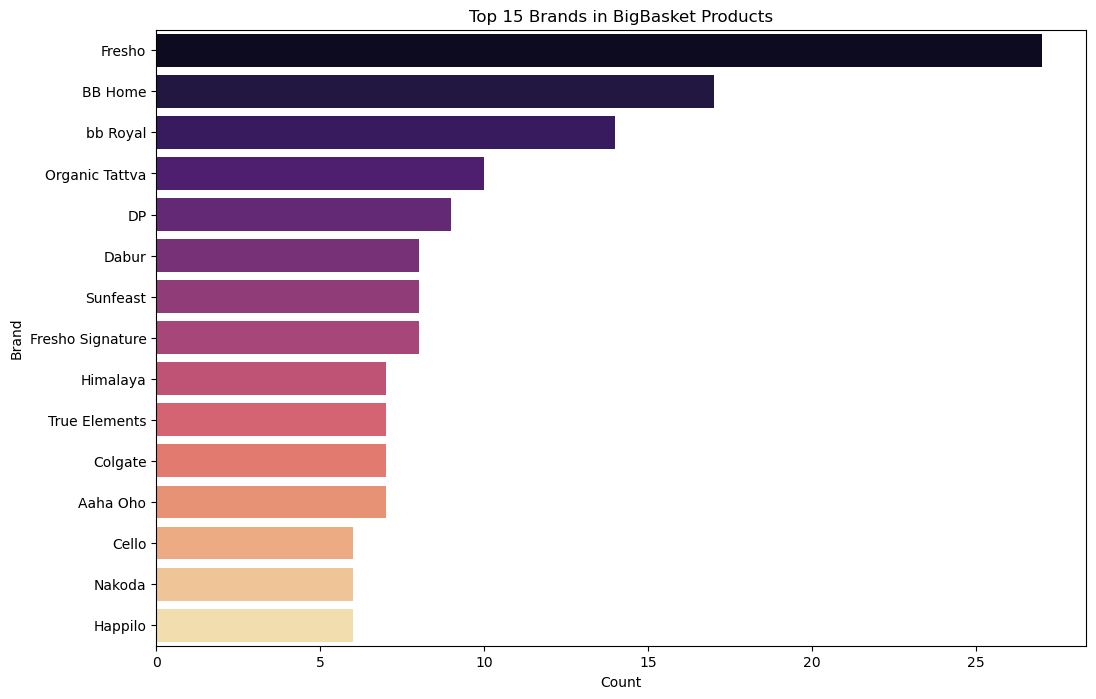

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
bigbasket_pandas_df = bigbasket_df.toPandas()

# Brand Distribution
plt.figure(figsize=(12, 8))
top_brands = bigbasket_pandas_df['ProductBrand'].value_counts().head(15)
sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')
plt.title('Top 15 Brands in BigBasket Products')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.show()


# Data Transformation and Combination

In [60]:
# Load datasets
bigbasket_df = spark.read.csv("Bigbasket_catlog.csv", header=True, inferSchema=True)
myntra_df = spark.read.csv("myntra_catalog.csv", header=True, inferSchema=True)

# Print column names of both DataFrames
print("BigBasket DataFrame Columns:", bigbasket_df.columns)
print("Myntra DataFrame Columns:", myntra_df.columns)

# Rename columns for consistency before joining
bigbasket_df = bigbasket_df.withColumnRenamed("Product", "name")
myntra_df = myntra_df.withColumnRenamed("ProductName", "name")

# Merge datasets on the common column 'name'
merged_df = bigbasket_df.join(myntra_df, on=["name"], how="outer")

# Show the combined dataset
merged_df.show(5)


BigBasket DataFrame Columns: ['ProductID', 'Product', 'Category', 'Sub_category', 'ProductBrand', 'Price  ', 'Market_price', 'Type', 'Rating']
Myntra DataFrame Columns: ['ProductID', 'ProductName', 'ProductBrand', 'Gender', 'Myntra_Price', 'NumImages', 'PrimaryColor']
+--------------------+---------+--------------------+--------------------+------------+-------+------------+--------------------+------+---------+------------+------+------------+---------+------------+
|                name|ProductID|            Category|        Sub_category|ProductBrand|Price  |Market_price|                Type|Rating|ProductID|ProductBrand|Gender|Myntra_Price|NumImages|PrimaryColor|
+--------------------+---------+--------------------+--------------------+------------+-------+------------+--------------------+------+---------+------------+------+------------+---------+------------+
|"Spring Roll Shee...|      823|Snacks & Branded ...|Frozen Veggies & ...|       Switz|  100.0|       110.0|   Frozen Veg 

# Exploratory Study: 

In [62]:
from pyspark.sql import SparkSession

# Descriptive statistics
merged_df.show()




+--------------------+---------+--------------------+--------------------+------------+-------+------------+--------------------+------+---------+------------+------+------------+---------+------------+
|                name|ProductID|            Category|        Sub_category|ProductBrand|Price  |Market_price|                Type|Rating|ProductID|ProductBrand|Gender|Myntra_Price|NumImages|PrimaryColor|
+--------------------+---------+--------------------+--------------------+------------+-------+------------+--------------------+------+---------+------------+------+------------+---------+------------+
|"Spring Roll Shee...|      823|Snacks & Branded ...|Frozen Veggies & ...|       Switz|  100.0|       110.0|   Frozen Veg Snacks|   4.0|     NULL|        NULL|  NULL|        NULL|     NULL|        NULL|
|& Moms Bathing So...|       78|    Beauty & Hygiene|    Bath & Hand Wash|      Dettol|  108.0|       120.0|Bathing Bars & Soaps|   4.6|     NULL|        NULL|  NULL|        NULL|     NULL

# EDA for Combine Dataset

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert PySpark DataFrames to Pandas DataFrames
myntra_pandas_df = myntra_df.toPandas()
bigbasket_pandas_df = bigbasket_df.toPandas()

# Convert infinite values to NaN
myntra_pandas_df.replace([np.inf, -np.inf], np.nan, inplace=True)
bigbasket_pandas_df.replace([np.inf, -np.inf], np.nan, inplace=True)



Myntra DataFrame columns: Index(['ProductID', 'name', 'ProductBrand', 'Gender', 'Myntra_Price',
       'NumImages', 'PrimaryColor'],
      dtype='object')
BigBasket DataFrame columns: Index(['ProductID', 'name', 'Category', 'Sub_category', 'ProductBrand',
       'Price  ', 'Market_price', 'Type', 'Rating'],
      dtype='object')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


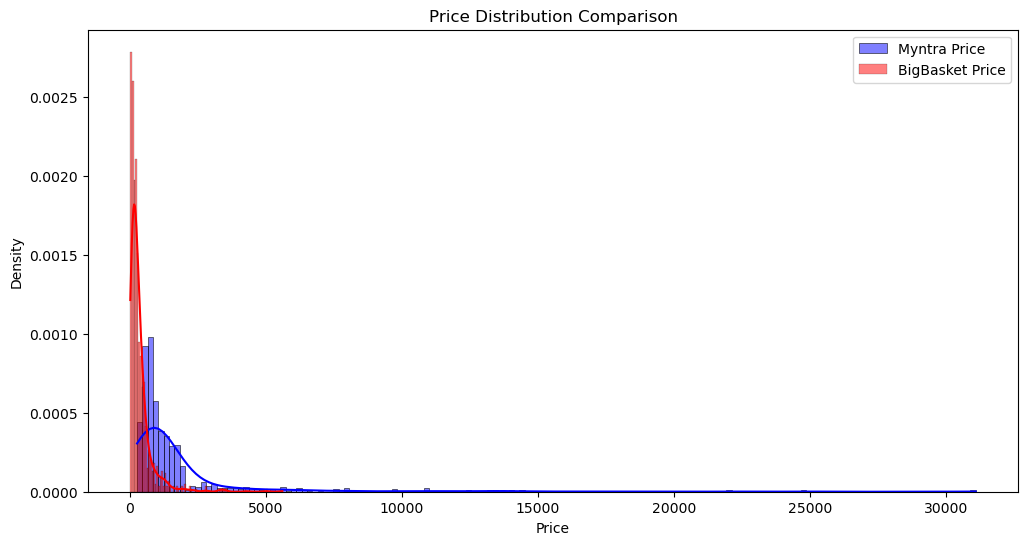

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrames to Pandas DataFrames
myntra_pandas_df = myntra_df.toPandas()
bigbasket_pandas_df = bigbasket_df.toPandas()

# Print column names to check for the correct key
print("Myntra DataFrame columns:", myntra_pandas_df.columns)
print("BigBasket DataFrame columns:", bigbasket_pandas_df.columns)

# Assuming the correct column name for BigBasket prices is found and adjusted in the plot code
plt.figure(figsize=(12, 6))
sns.histplot(myntra_pandas_df['Myntra_Price'], color='blue', label='Myntra Price', kde=True, stat='density')

# Correct the column name according to the output of bigbasket_pandas_df.columns
sns.histplot(bigbasket_pandas_df['Market_price'], color='red', label='BigBasket Price', kde=True, stat='density')  # Adjust 'BigBasket_Price' if that is the correct column name

plt.title('Price Distribution Comparison')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()


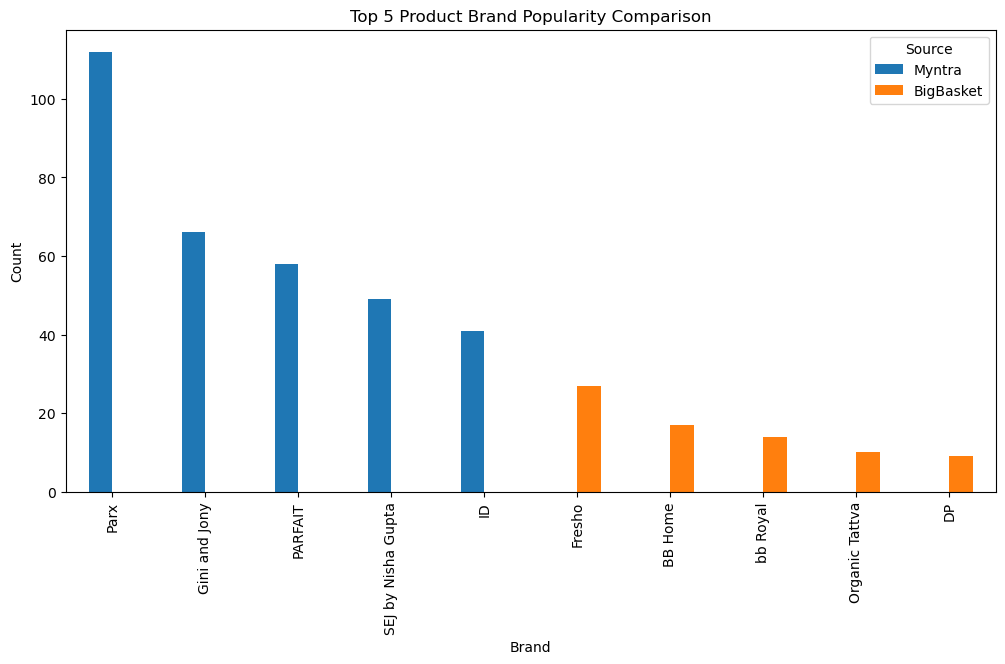

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrames to Pandas DataFrames
myntra_pandas_df = myntra_df.toPandas()
bigbasket_pandas_df = bigbasket_df.toPandas()

# Get the top 5 brands from each DataFrame
top5_myntra = myntra_pandas_df['ProductBrand'].value_counts().head(5)
top5_bigbasket = bigbasket_pandas_df['ProductBrand'].value_counts().head(5)

# Combine the top 5 brands into a single DataFrame for comparison
combined_brands = pd.concat([top5_myntra, top5_bigbasket], axis=1, keys=['Myntra', 'BigBasket'])

# Fill NaN values with 0 if any brands do not match across DataFrames
combined_brands.fillna(0, inplace=True)

# Plot the comparison
combined_brands.plot(kind='bar', figsize=(12, 6))
plt.title('Top 5 Product Brand Popularity Comparison')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()


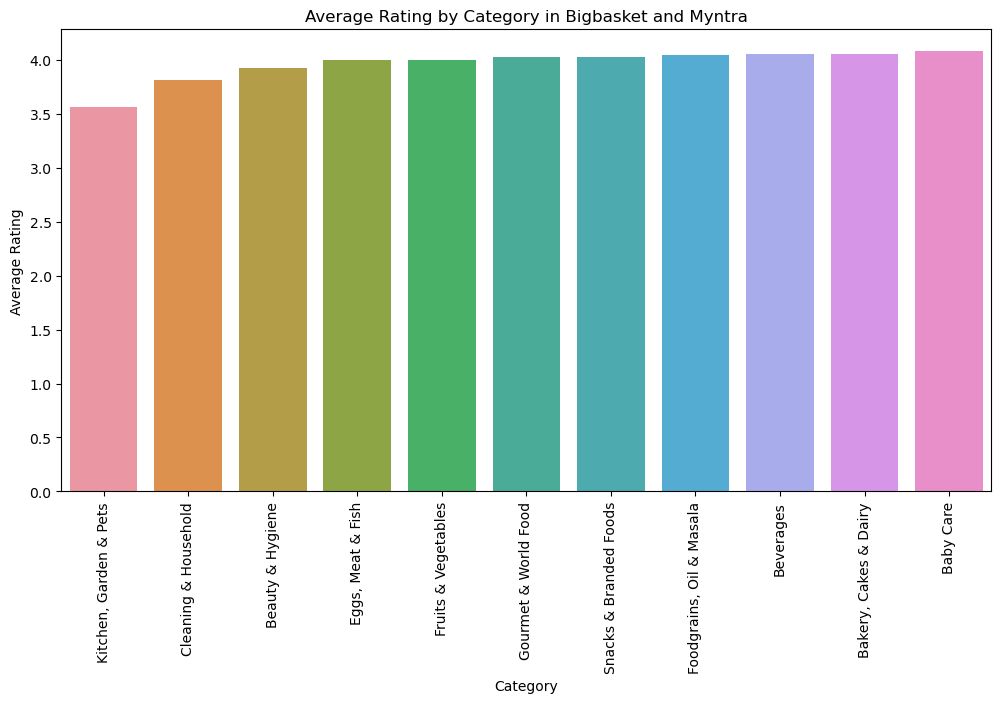

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Conversion (assuming this has been done as per your last message)
myntra_pandas_df = myntra_df.toPandas()
bigbasket_pandas_df = bigbasket_df.toPandas()

# Visualization 3: Average Rating by Category in Bigbasket
plt.figure(figsize=(12, 6))
category_ratings = bigbasket_pandas_df.groupby('Category')['Rating'].mean().sort_values()
sns.barplot(x=category_ratings.index, y=category_ratings.values)
plt.title('Average Rating by Category in Bigbasket and Myntra')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()


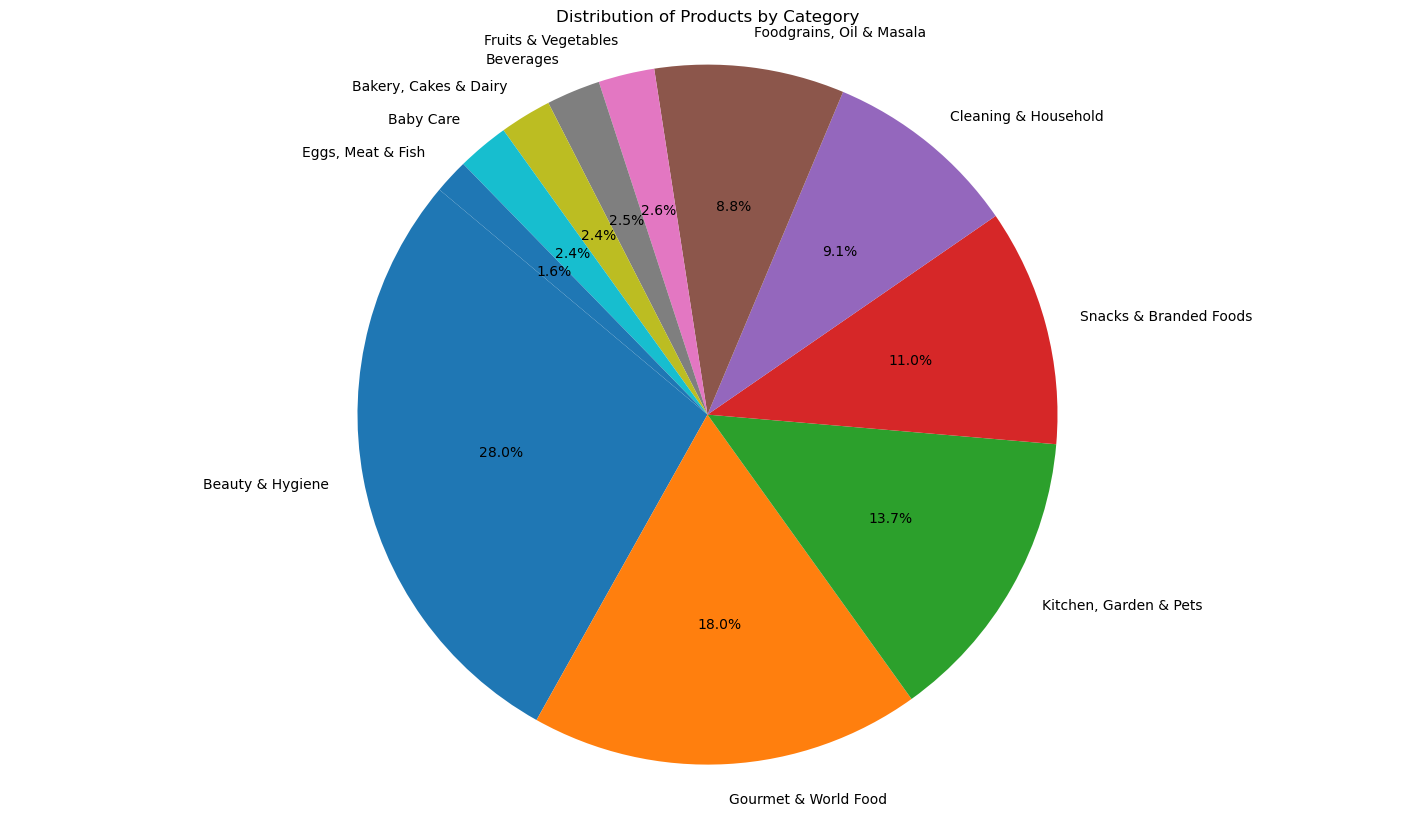

In [77]:
import matplotlib.pyplot as plt

# Step 1: Aggregate the data
category_counts = bigbasket_pandas_df['Category'].value_counts()

# Step 2: Plot the pie chart
plt.figure(figsize=(18, 10))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Products by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [79]:
from pyspark.sql.functions import col

category_counts = bigbasket_df.groupBy("Category").count().orderBy(col("count").desc())


In [81]:
brand_counts = bigbasket_df.groupBy("ProductBrand").count().orderBy(col("count").desc()).limit(10)


In [83]:
# Convert merged PySpark DataFrame to Pandas DataFrame for visualization
merged_pandas_df = merged_df.toPandas()

# Print the columns of the merged DataFrame
print(merged_pandas_df.columns)



Index(['name', 'ProductID', 'Category', 'Sub_category', 'ProductBrand',
       'Price  ', 'Market_price', 'Type', 'Rating', 'ProductID',
       'ProductBrand', 'Gender', 'Myntra_Price', 'NumImages', 'PrimaryColor'],
      dtype='object')


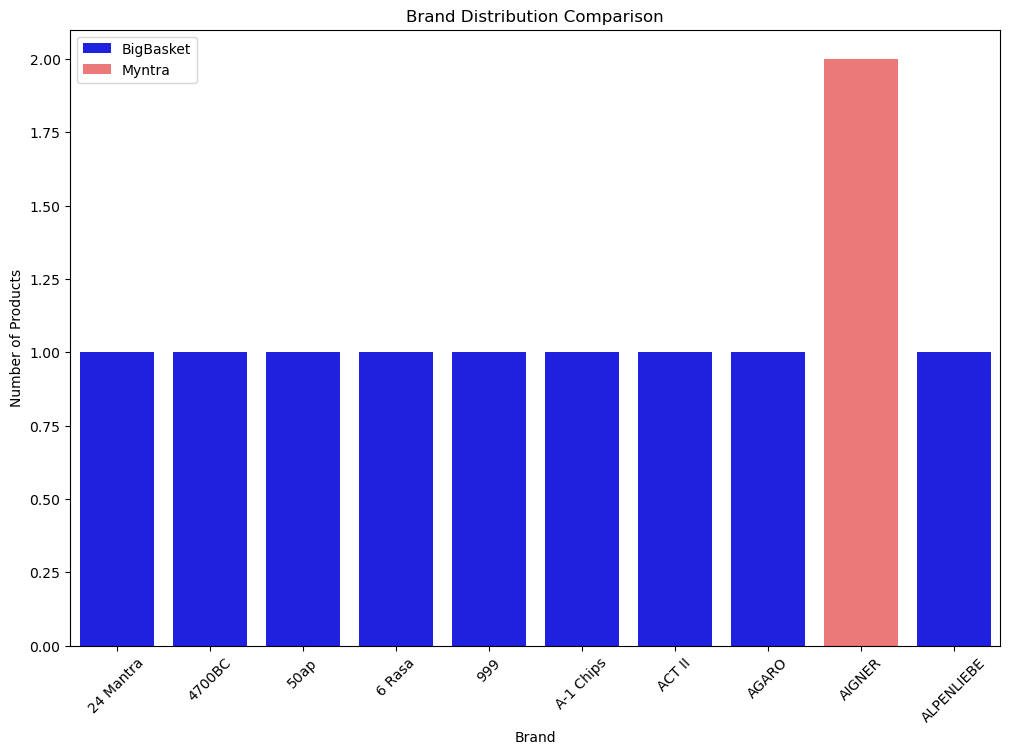

In [85]:
# Aggregate data to get counts per brand for each platform
brand_distribution_bb = bigbasket_df.groupBy("ProductBrand").count().withColumnRenamed("count", "BB_Count")
brand_distribution_my = myntra_df.groupBy("ProductBrand").count().withColumnRenamed("count", "MY_Count")

# Join the data on brand name
brand_distribution = brand_distribution_bb.join(brand_distribution_my, ["ProductBrand"], "outer")

# Convert to Pandas DataFrame for visualization
brand_distribution_pandas = brand_distribution.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=brand_distribution_pandas.head(10), x="ProductBrand", y="BB_Count", color="blue", label="BigBasket")
sns.barplot(data=brand_distribution_pandas.head(10), x="ProductBrand", y="MY_Count", color="red", alpha=0.6, label="Myntra")
plt.title('Brand Distribution Comparison')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Data Analysis Preparation


### 1.Normalization

In [89]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Strip leading/trailing spaces from column names
merged_df = merged_df.withColumnRenamed("Price  ", "Price")

# Remove rows with null values in the 'Price' column
cleaned_df = merged_df.filter(merged_df["Price"].isNotNull())

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=["Price"], outputCol="price_vector")
assembled_df = assembler.transform(cleaned_df)

# Normalize the data
scaler = StandardScaler(inputCol="price_vector", outputCol="scaled_price", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
normalized_df = scaler_model.transform(assembled_df)

# Show the normalized data
normalized_df.select("name", "Price", "scaled_price").show(5)


+--------------------+-----+--------------------+
|                name|Price|        scaled_price|
+--------------------+-----+--------------------+
|Garlic Oil - Vege...|220.0|[-0.1813042499287...|
|Water Bottle - Or...|180.0|[-0.2762271118687...|
|Brass Angle Deep ...|119.0|[-0.4209844763272...|
|Cereal Flip Lid C...|149.0|[-0.3497923298722...|
|Creme Soft Soap -...|162.0|[-0.3189423997417...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [91]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Strip leading/trailing spaces from column names
merged_df = merged_df.withColumnRenamed("Price  ", "Price")

# Assemble the features into a vector and handle invalid (null) values
assembler = VectorAssembler(inputCols=["Price"], outputCol="price_vector", handleInvalid="skip")
assembled_df = assembler.transform(merged_df)

# Normalize the data
scaler = StandardScaler(inputCol="price_vector", outputCol="scaled_price", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
normalized_df = scaler_model.transform(assembled_df)

# Show the normalized data
normalized_df.select("name", "Price", "scaled_price").show(5)


+--------------------+-----+--------------------+
|                name|Price|        scaled_price|
+--------------------+-----+--------------------+
|Garlic Oil - Vege...|220.0|[-0.1813042499287...|
|Water Bottle - Or...|180.0|[-0.2762271118687...|
|Brass Angle Deep ...|119.0|[-0.4209844763272...|
|Cereal Flip Lid C...|149.0|[-0.3497923298722...|
|Creme Soft Soap -...|162.0|[-0.3189423997417...|
+--------------------+-----+--------------------+
only showing top 5 rows



### Feature selection

In [94]:
# Feature selection
selected_features = ["name", "category", "scaled_price"]
final_df = normalized_df.select(*selected_features)

# Show the prepared data
final_df.show(5)


+--------------------+--------------------+--------------------+
|                name|            category|        scaled_price|
+--------------------+--------------------+--------------------+
|Garlic Oil - Vege...|    Beauty & Hygiene|[-0.1813042499287...|
|Water Bottle - Or...|Kitchen, Garden &...|[-0.2762271118687...|
|Brass Angle Deep ...|Cleaning & Household|[-0.4209844763272...|
|Cereal Flip Lid C...|Cleaning & Household|[-0.3497923298722...|
|Creme Soft Soap -...|    Beauty & Hygiene|[-0.3189423997417...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



# Scalability and Performance Considerations

In [97]:
# Repartition the data to optimize performance
final_df = final_df.repartition(10)


In [99]:
# Use caching to improve performance
final_df.cache()

# Example of parallel processing: Count distinct categories
from pyspark.sql.functions import countDistinct

distinct_categories = final_df.select(countDistinct("category")).collect()
print(f"Number of distinct categories: {distinct_categories[0][0]}")


Number of distinct categories: 11


In [101]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MapReduce Analysis") \
    .getOrCreate()

# Load the combined dataset
merged_df = spark.read.csv("myntra_catalog.csv", header=True, inferSchema=True)

# Print DataFrame columns to verify the column names
print("DataFrame columns:", merged_df.columns)

# Assuming 'Category' column is correctly named and exists, convert DataFrame to RDD for MapReduce operations
rdd = merged_df.rdd

# Map phase: Create key-value pairs (category, (price, 1))
# Make sure the column names used here match those printed out
mapped_rdd = rdd.map(lambda row: (row['ProductBrand'], (row['Myntra_Price'], 1)))

# Show a few mapped key-value pairs
print(mapped_rdd.take(5))



24/05/20 17:08:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


DataFrame columns: ['ProductID', 'ProductName', 'ProductBrand', 'Gender', 'Myntra_Price', 'NumImages', 'PrimaryColor']
[('DKNY', (11745, 1)), ('EthnoVogue', (5810, 1)), ('SPYKAR', (899, 1)), ('Raymond', (5599, 1)), ('Parx', (759, 1))]


In [102]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MapReduce Analysis") \
    .getOrCreate()

# Load the combined dataset
merged_df = spark.read.csv("Bigbasket_catlog.csv", header=True, inferSchema=True)

# Print DataFrame columns to verify the column names
print("DataFrame columns:", merged_df.columns)

# Assuming 'Category' column is correctly named and exists, convert DataFrame to RDD for MapReduce operations
rdd = merged_df.rdd

# Map phase: Create key-value pairs (category, (price, 1))
# Make sure the column names used here match those printed out
mapped_rdd = rdd.map(lambda row: (row['Category'], (row['Market_price'], 1)))

# Show a few mapped key-value pairs
print(mapped_rdd.take(5))



DataFrame columns: ['ProductID', 'Product', 'Category', 'Sub_category', 'ProductBrand', 'Price  ', 'Market_price', 'Type', 'Rating']
[('Beauty & Hygiene', (220.0, 1)), ('Kitchen, Garden & Pets', (180.0, 1)), ('Cleaning & Household', (250.0, 1)), ('Cleaning & Household', (176.0, 1)), ('Beauty & Hygiene', (162.0, 1))]


In [105]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MapReduce Analysis") \
    .getOrCreate()

# Load the dataset
data = spark.read.csv("myntra_catalog.csv", header=True, inferSchema=True)
rdd = data.rdd

# Map phase: create (key, value) pairs
mapped_rdd = rdd.map(lambda row: (row['ProductBrand'], (row['Myntra_Price'], 1)))

# Reduce phase: sum prices and counts per category
reduced_rdd = mapped_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Calculate average price per category
average_price_rdd = reduced_rdd.map(lambda x: (x[0], x[1][0] / x[1][1]))

# Collect the result
average_prices = average_price_rdd.collect()
for category, avg_price in average_prices:
    print(category, avg_price)


DKNY 15690.384615384615
EthnoVogue 5256.75
SPYKAR 1244.1470588235295
Raymond 1812.9615384615386
Parx 722.0089285714286
SHOWOFF 805.6666666666666
Kenneth Cole 2400.0
Police 2035.5
Vishudh 1199.8125
Being Human 1079.0
Homesake 1761.4666666666667
SEJ by Nisha Gupta 888.795918367347
YAK YAK 599.0
PARFAIT 1449.5172413793102
Michael Kors 6375.0
HIGHLANDER 880.8181818181819
JEWEL JUNCTION 539.0
ID 1810.0731707317073
Story@home 1413.2857142857142
Gini and Jony 848.1666666666666
Sera 1168.0
AccessHer 889.7931034482758
Alcis 749.0
Difference of Opinion 499.0
Tokyo Talkies 748.25
ANNA SUI 4600.0
her by invictus 1419.5882352941176
Soie 754.6470588235294
Lara Karen 1999.0
Urban Dog 420.42857142857144
ahilya 6284.64705882353
VASTRAMAY 1361.5
Campus Sutra 698.5
FIDO DIDO 911.5
MIAH Decor 1386.7058823529412
BuckleUp 449.0
Peter England 266.0
AIGNER 3995.0
Lady Lyka 503.51724137931035
Park Avenue 818.5294117647059
Roadster 1224.0
U.S. Polo Assn. Denim Co. 3499.0
Sweet Dreams 699.0
Kazo 2318.75
Stylo Bu

In [107]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MapReduce Analysis") \
    .getOrCreate()

# Load the dataset
data = spark.read.csv("Bigbasket_catlog.csv", header=True, inferSchema=True)
rdd = data.rdd

# Map phase: create (key, value) pairs
mapped_rdd = rdd.map(lambda row: (row['Category'], (row['Market_price'], 1)))

# Reduce phase: sum prices and counts per category
reduced_rdd = mapped_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Calculate average price per category
average_price_rdd = reduced_rdd.map(lambda x: (x[0], x[1][0] / x[1][1]))

# Collect the result
average_prices = average_price_rdd.collect()
for category, avg_price in average_prices:
    print(category, avg_price)


Beauty & Hygiene 412.9501779359431
Kitchen, Garden & Pets 641.1521739130435
Cleaning & Household 264.45054945054943
Gourmet & World Food 363.1325966850829
Foodgrains, Oil & Masala 162.8181818181818
Snacks & Branded Foods 158.6090909090909
Beverages 228.56
Bakery, Cakes & Dairy 117.45833333333333
Baby Care 430.5416666666667
Fruits & Vegetables 59.81269230769231
Eggs, Meat & Fish 375.5625
